In [1]:
import json
from utils.OpenMeteoWeather import OpenMeteoWeather
from utils.Copernicus import AdvancedCopernicus

output_filename = "output.nc"
start_datetime = "2024-12-31T00:00:00Z"
end_datetime = "2025-02-01T23:59:59Z"

latitude = 54.793
longitude = 9.441
val_range = 0.5

minimum_latitude = latitude - val_range
maximum_latitude = latitude + val_range
minimum_longitude = longitude - val_range
maximum_longitude = longitude + val_range



ac = AdvancedCopernicus()

ac_data = ac.get_subset(
                dataset_id="cmems_mod_glo_phy_anfc_0.083deg_PT1H-m",
                dataset_version="202406",
                variables=["so", "thetao", "vo", "zos", "uo"], 
                minimum_longitude=minimum_longitude,
                maximum_longitude=maximum_longitude,
                minimum_latitude=minimum_latitude,
                maximum_latitude=maximum_latitude,
                start_datetime=start_datetime,
                end_datetime=end_datetime,
                minimum_depth=0.49402499198913574,
                maximum_depth=0.49402499198913574,
                coordinates_selection_method="strict-inside",
                disable_progress_bar=False,
                output_filename=output_filename
                )
ac.delete_dataset(output_filename)

# convert datetime to YYYY-MM-DD
start_datetime = start_datetime.split("T")[0]
end_datetime = end_datetime.split("T")[0]



omw = OpenMeteoWeather(latitude=latitude, 
                       longitude=longitude, 
                       start_date=start_datetime, 
                       end_date=end_datetime)
df_omw = omw.get_weather_dataframe()




INFO - 2025-02-14T19:29:29Z - Selected dataset version: "202406"
INFO - 2025-02-14T19:29:29Z - Selected dataset part: "default"
INFO - 2025-02-14T19:29:35Z - Starting download. Please wait...


  0%|          | 0/10 [00:00<?, ?it/s]

INFO - 2025-02-14T19:29:38Z - Successfully downloaded to output.nc


In [2]:
# to dataframe
df_ac = ac_data.to_dataframe().reset_index().dropna(axis=0, how='any')
#display(df_ac.head())
# convert datetime to YYYY-MM-DD HH:MM:SS
df_ac["time"] = df_ac["time"].dt.strftime('%Y-%m-%d %H:%M:%S')

df_ac_grouped = df_ac.groupby("time").mean().reset_index()
display(df_ac_grouped.head())

,time,depth,latitude,longitude,so,thetao,vo,zos,uo
0,2024-12-31 00:00:00,0.494025,54.961117,9.663894,15.235150,6.268527,-0.019968,-0.355461,0.019862
1,2024-12-31 01:00:00,0.494025,54.961117,9.663894,15.241725,6.270809,-0.037948,-0.337176,0.028817
2,2024-12-31 02:00:00,0.494025,54.961117,9.663894,15.249771,6.272256,-0.051972,-0.323403,0.035113
3,2024-12-31 03:00:00,0.494025,54.961117,9.663894,15.258920,6.273057,-0.059917,-0.310542,0.038097
4,2024-12-31 04:00:00,0.494025,54.961117,9.663894,15.268523,6.273556,-0.062551,-0.298909,0.040204


In [3]:
# convert date to YYYY-MM-DD HH:MM:SS
df_omw["date"] = df_omw["date"].dt.strftime('%Y-%m-%d %H:%M:%S')
df_omw.groupby("date").mean().reset_index()
display(df_omw.head())

,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,showers,snowfall,...,temperature_180m,soil_temperature_0cm,soil_temperature_6cm,soil_temperature_18cm,soil_temperature_54cm,soil_moisture_0_to_1cm,soil_moisture_1_to_3cm,soil_moisture_3_to_9cm,soil_moisture_9_to_27cm,soil_moisture_27_to_81cm
0,2024-12-30 23:00:00,7.893000,92.0,6.673273,2.930048,43.0,0.0,0.0,0.0,0.0,...,6.443,7.443000,7.793,7.543,6.793,0.363,0.364,0.364,0.366,0.372
1,2024-12-31 00:00:00,8.393000,93.0,7.326519,3.751252,45.0,0.0,0.0,0.0,0.0,...,7.043,8.092999,8.243,7.593,6.793,0.364,0.364,0.365,0.366,0.372
2,2024-12-31 01:00:00,8.292999,93.0,7.227365,4.109541,45.0,0.0,0.0,0.0,0.0,...,6.943,7.843000,8.193,7.593,6.793,0.365,0.365,0.366,0.367,0.373
3,2024-12-31 02:00:00,7.993000,94.0,7.086014,4.037975,53.0,0.1,0.1,0.0,0.0,...,6.643,7.543000,8.043,7.643,6.843,0.366,0.366,0.367,0.368,0.373
4,2024-12-31 03:00:00,8.092999,95.0,7.340065,4.022114,38.0,0.0,0.0,0.0,0.0,...,6.743,7.693000,8.143,7.643,6.843,0.357,0.357,0.357,0.359,0.368


In [4]:
# merge dataframes
df_merged = df_ac_grouped.merge(df_omw, left_on="time", right_on="date").drop(columns=["date"])
display(df_merged.head())

,time,depth,latitude,longitude,so,thetao,vo,zos,uo,temperature_2m,...,temperature_180m,soil_temperature_0cm,soil_temperature_6cm,soil_temperature_18cm,soil_temperature_54cm,soil_moisture_0_to_1cm,soil_moisture_1_to_3cm,soil_moisture_3_to_9cm,soil_moisture_9_to_27cm,soil_moisture_27_to_81cm
0,2024-12-31 00:00:00,0.494025,54.961117,9.663894,15.235150,6.268527,-0.019968,-0.355461,0.019862,8.393000,...,7.043,8.092999,8.243,7.593,6.793,0.364,0.364,0.365,0.366,0.372
1,2024-12-31 01:00:00,0.494025,54.961117,9.663894,15.241725,6.270809,-0.037948,-0.337176,0.028817,8.292999,...,6.943,7.843000,8.193,7.593,6.793,0.365,0.365,0.366,0.367,0.373
2,2024-12-31 02:00:00,0.494025,54.961117,9.663894,15.249771,6.272256,-0.051972,-0.323403,0.035113,7.993000,...,6.643,7.543000,8.043,7.643,6.843,0.366,0.366,0.367,0.368,0.373
3,2024-12-31 03:00:00,0.494025,54.961117,9.663894,15.258920,6.273057,-0.059917,-0.310542,0.038097,8.092999,...,6.743,7.693000,8.143,7.643,6.843,0.357,0.357,0.357,0.359,0.368
4,2024-12-31 04:00:00,0.494025,54.961117,9.663894,15.268523,6.273556,-0.062551,-0.298909,0.040204,7.893000,...,6.443,7.493000,7.993,7.643,6.843,0.357,0.358,0.358,0.360,0.368


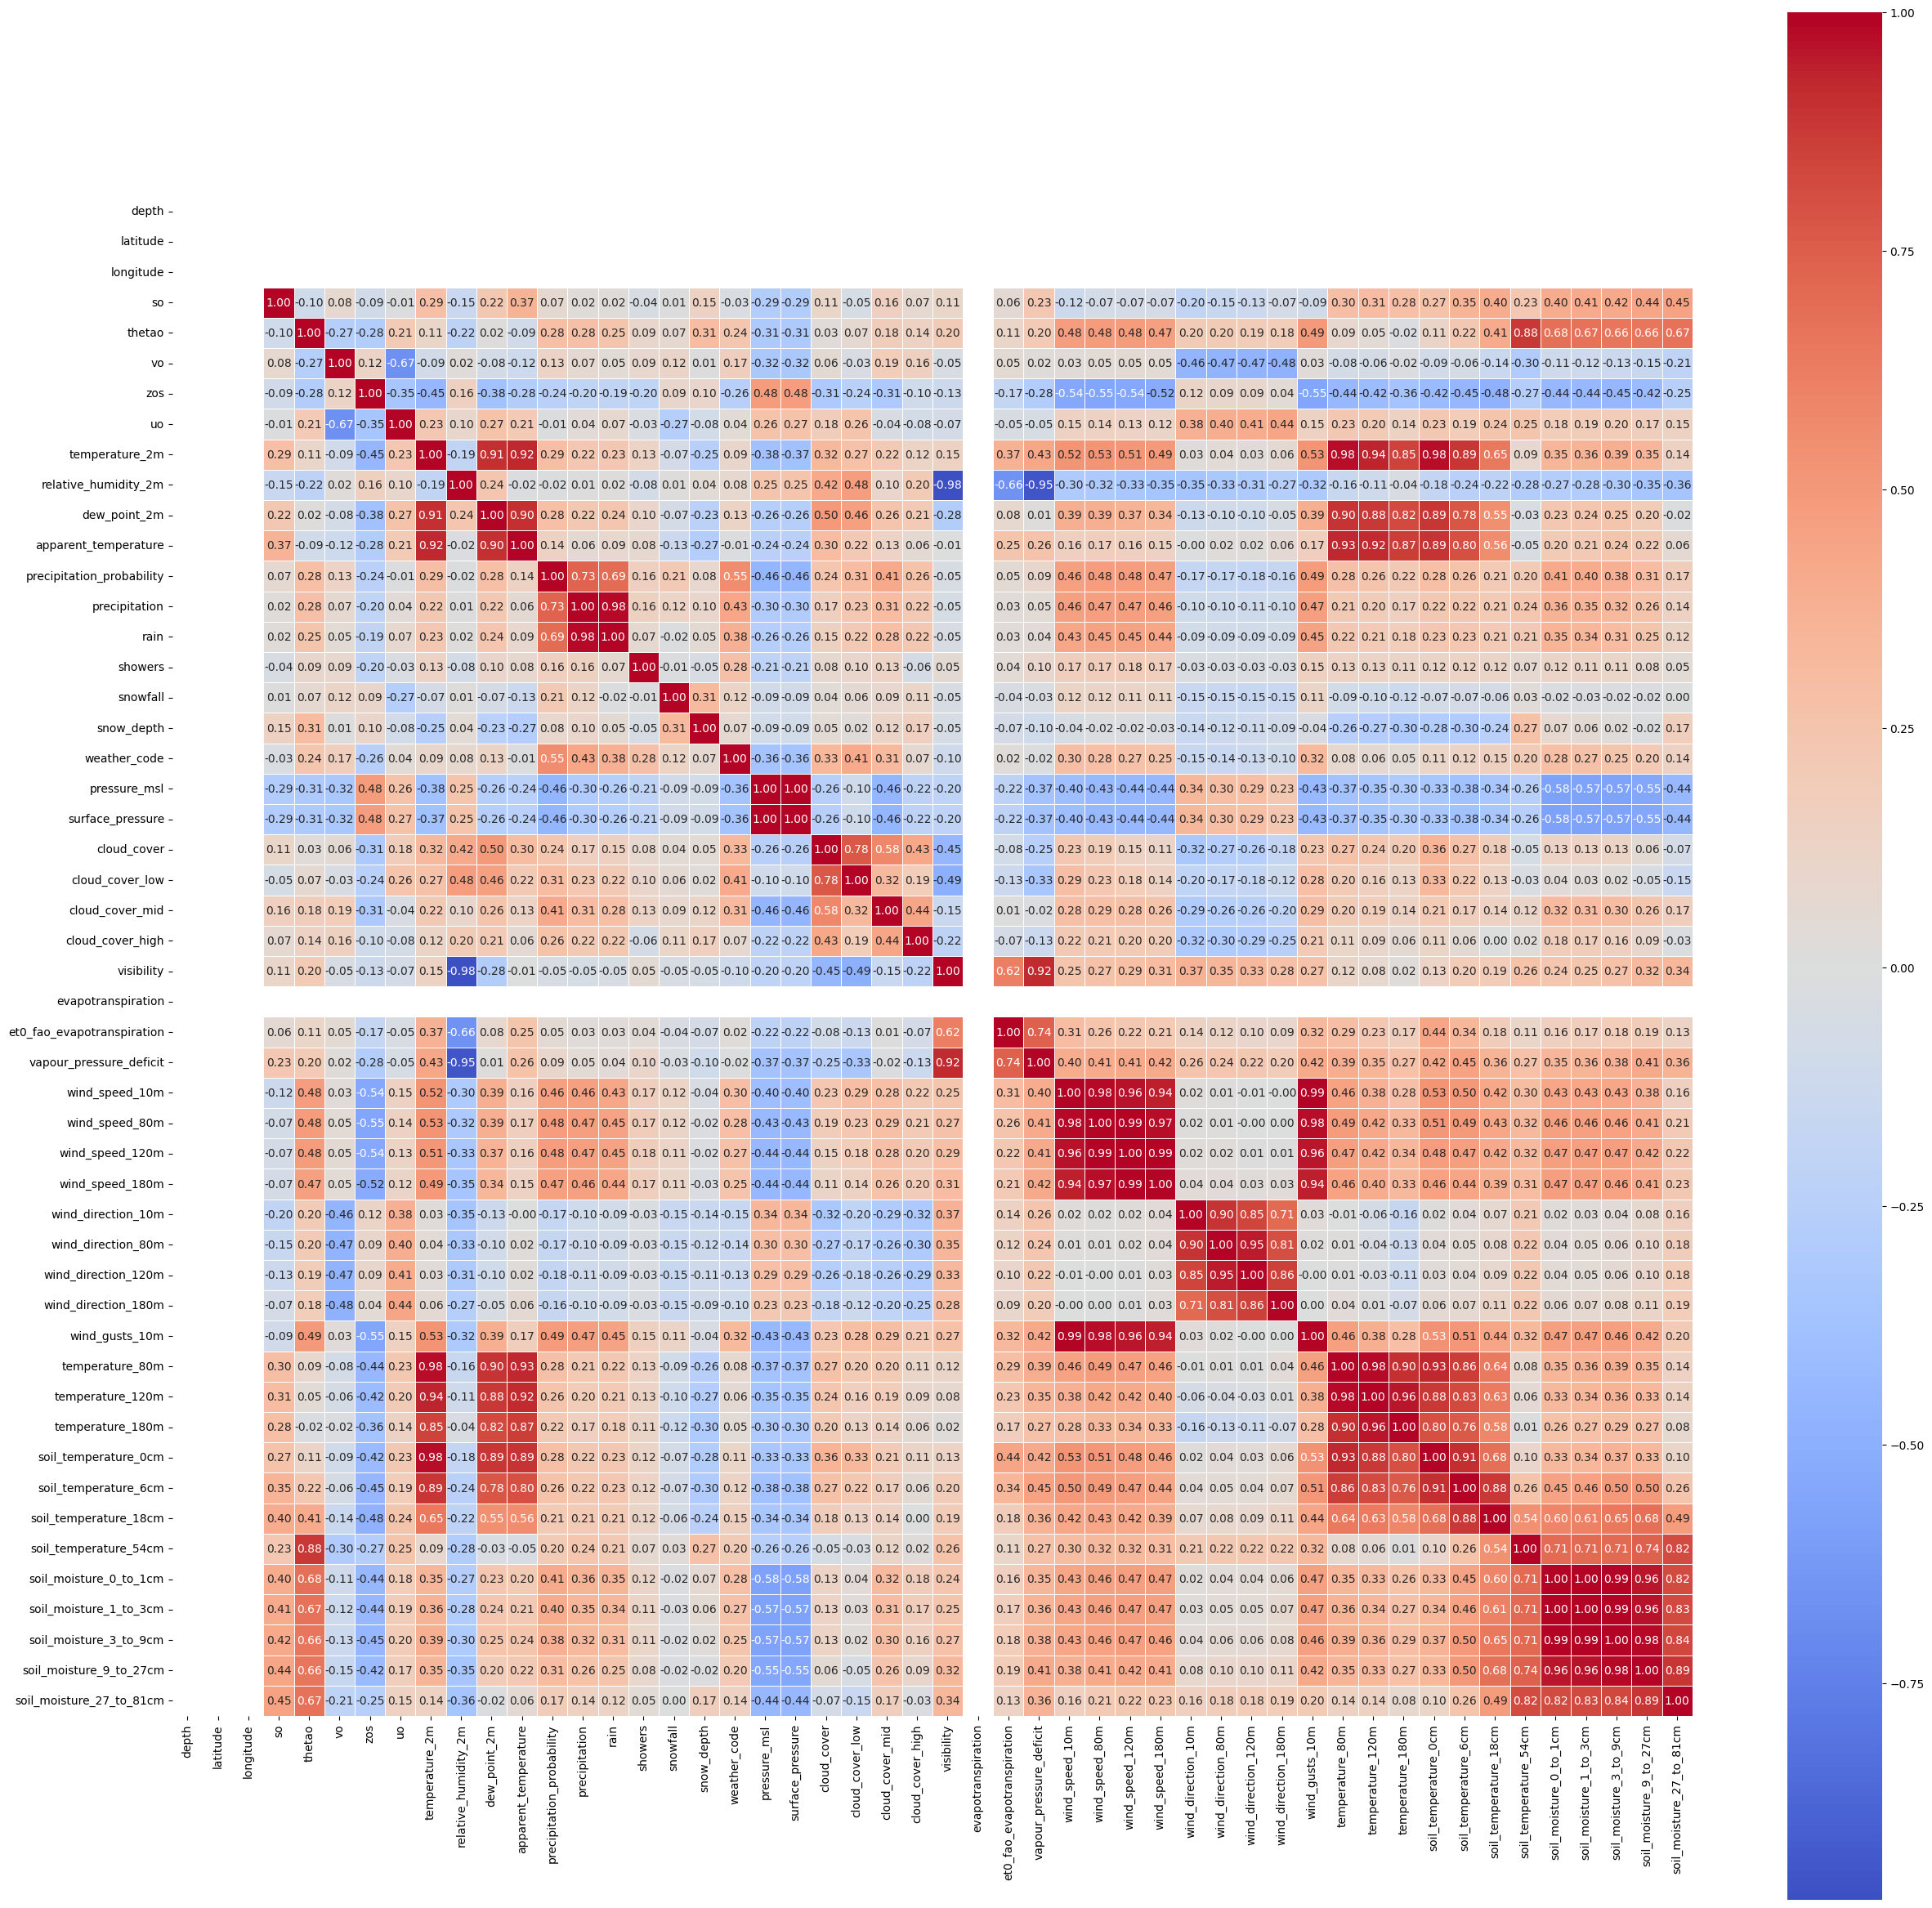

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot correlation
corr = df_merged.corr(numeric_only=True)

plt.figure(figsize=(30, 30))

# pallette = sns.diverging_palette(220, 20, n=7)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True, linewidths=.5)
plt.show()



In [6]:
df = df_merged.drop(columns=["time"])

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np

# # Dummy DataFrame (ersetzen mit echtem Datensatz)
features = ['depth', 'latitude', 'longitude', 'so', 'thetao', 'vo', 'uo', 'temperature_2m', 
            'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature', 'precipitation_probability',
            'precipitation', 'rain', 'showers', 'snowfall', 'snow_depth', 'weather_code',
            'pressure_msl', 'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 
            'cloud_cover_high', 'visibility', 'evapotranspiration', 'et0_fao_evapotranspiration', 
            'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_80m', 'wind_speed_120m', 'wind_speed_180m',
            'wind_direction_10m', 'wind_direction_80m', 'wind_direction_120m', 'wind_direction_180m', 
            'wind_gusts_10m', 'temperature_80m', 'temperature_120m', 'temperature_180m', 'soil_temperature_0cm',
            'soil_temperature_6cm', 'soil_temperature_18cm', 'soil_temperature_54cm', 'soil_moisture_0_to_1cm',
            'soil_moisture_1_to_3cm', 'soil_moisture_3_to_9cm', 'soil_moisture_9_to_27cm', 'soil_moisture_27_to_81cm']

# df = pd.DataFrame(np.random.rand(10000, len(features) + 1), columns=features + ['zos'])

# Daten vorbereiten
X = torch.tensor(df[features].values, dtype=torch.float32)
y = torch.tensor(df['zos'].values, dtype=torch.float32).view(-1, 1)

# Train-Test Split
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Neuronales Netzwerk definieren
class ZOSPredictor(nn.Module):
    def __init__(self, input_dim):
        super(ZOSPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Modell initialisieren
model = ZOSPredictor(input_dim=len(features))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

# Evaluierung
model.eval()
total_loss = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        total_loss += loss.item()

print(f"Test Loss: {total_loss/len(test_loader):.4f}")


Epoch 1, Loss: 5463.2782
Epoch 2, Loss: 903.6943
Epoch 3, Loss: 446.5052
Epoch 4, Loss: 245.7995
Epoch 5, Loss: 91.9604
Epoch 6, Loss: 35.1480
Epoch 7, Loss: 15.0073
Epoch 8, Loss: 7.7772
Epoch 9, Loss: 3.9494
Epoch 10, Loss: 2.2885
Epoch 11, Loss: 1.7935
Epoch 12, Loss: 1.6601
Epoch 13, Loss: 1.4451
Epoch 14, Loss: 1.3404
Epoch 15, Loss: 1.4788
Epoch 16, Loss: 1.2198
Epoch 17, Loss: 1.2389
Epoch 18, Loss: 1.1869
Epoch 19, Loss: 1.2632
Epoch 20, Loss: 1.4004
Epoch 21, Loss: 1.0633
Epoch 22, Loss: 1.0646
Epoch 23, Loss: 1.0998
Epoch 24, Loss: 1.0120
Epoch 25, Loss: 1.0597
Epoch 26, Loss: 1.5209
Epoch 27, Loss: 2.0216
Epoch 28, Loss: 3.1340
Epoch 29, Loss: 2.1464
Epoch 30, Loss: 3.6103
Epoch 31, Loss: 3.1359
Epoch 32, Loss: 1.6583
Epoch 33, Loss: 1.6436
Epoch 34, Loss: 0.9372
Epoch 35, Loss: 0.7384
Epoch 36, Loss: 0.7089
Epoch 37, Loss: 1.0665
Epoch 38, Loss: 0.7399
Epoch 39, Loss: 0.8882
Epoch 40, Loss: 0.9767
Epoch 41, Loss: 0.6175
Epoch 42, Loss: 0.5977
Epoch 43, Loss: 1.1751
Epoch 44

In [8]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()

# Beispielaufruf:
plot_loss(train_losses, val_losses)


NameError: name 'train_losses' is not defined